<a href="https://colab.research.google.com/github/YanaMinyaylo/NS/blob/main/FEDOT_7_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate
from scipy import signal
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

In [ ]:
dir4 = '/content/NS/data/NN_data/NN_data_Yana_2.csv'

In [ ]:
df = pd.read_csv(dir4)

In [ ]:
x = np.array(df['gx']).reshape(-1, 1)
y = np.array(df['Hor_eye']).reshape(-1, 1)

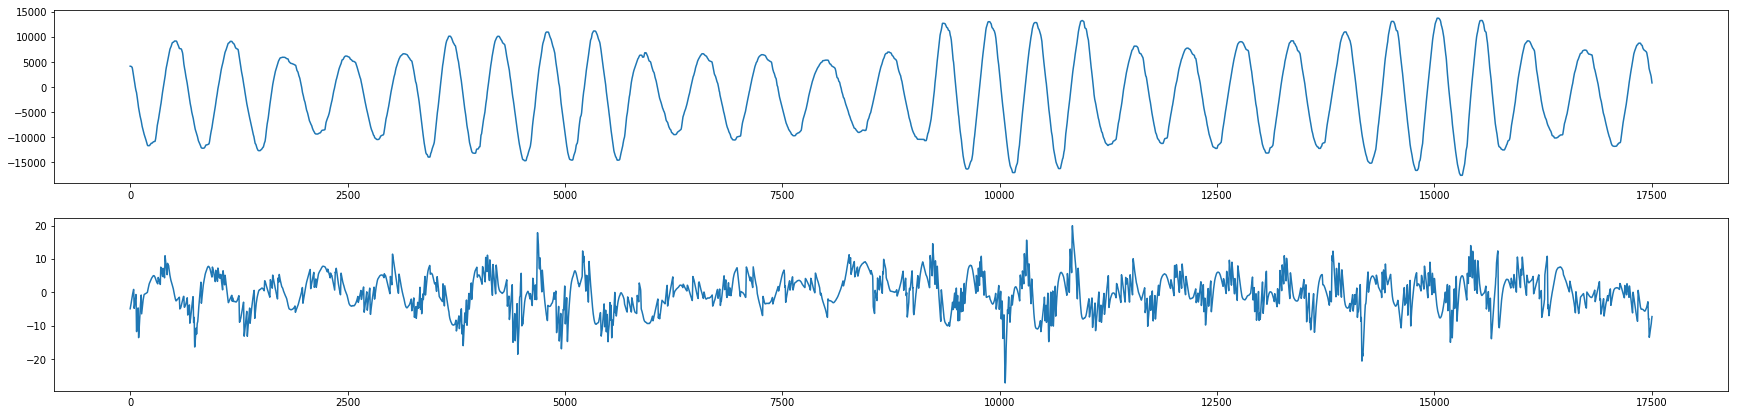

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows = 2, figsize=(30,7))
n1 = 0
n2 = -1
ax[0].plot(x[n1:n2], '-')
ax[1].plot(y[n1:n2], '-')

plt.show()

In [ ]:
x_scaler = MinMaxScaler((-1,1))
y_scaler = MinMaxScaler((-1,1))

scaled_x = x_scaler.fit_transform(x)
scaled_y = y_scaler.fit_transform(y)

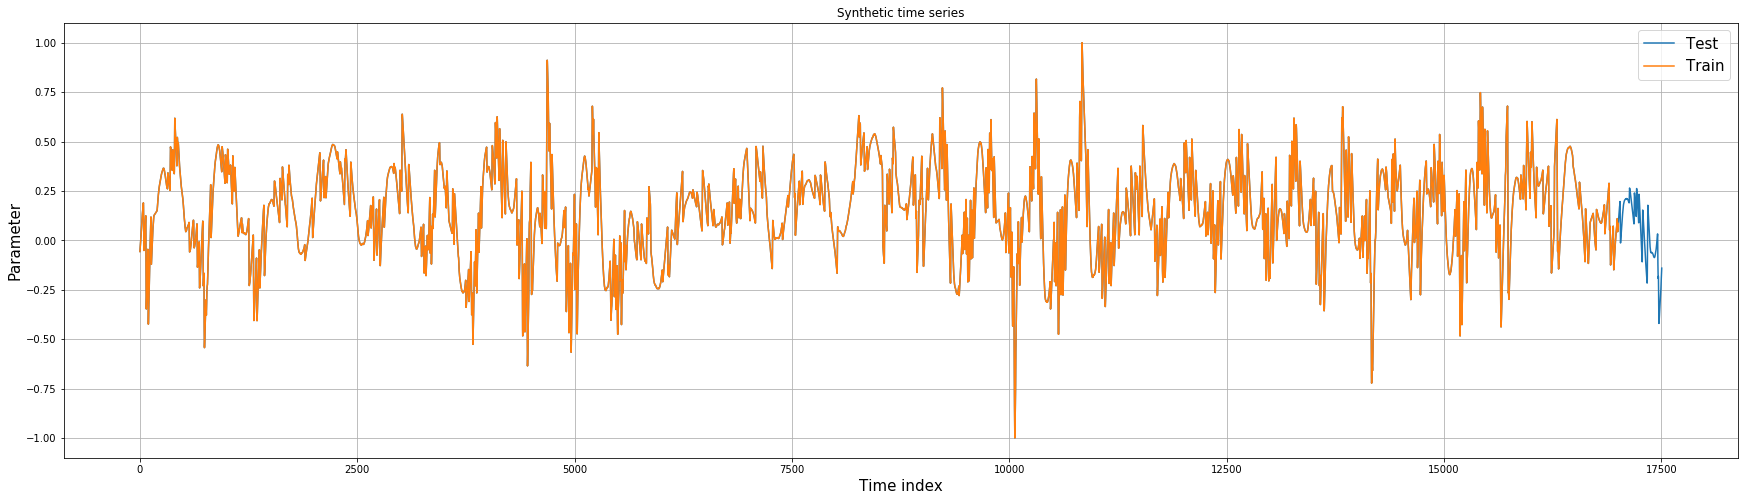

In [ ]:
# We will predict 100 values in the future
len_forecast = 500

# Let's dividide our data on train and test samples
y_train = scaled_y[:-len_forecast]
y_test = scaled_y[-len_forecast:]

x_train = scaled_x[:-len_forecast]
x_test = scaled_x[-len_forecast:]

# Plot time series
fig = plt.figure(figsize=(30,8))
plt.plot(np.arange(0, len(scaled_y)), scaled_y, label = 'Test')
plt.plot(np.arange(0, len(y_train)), y_train, label = 'Train')
plt.ylabel('Parameter', fontsize = 15)
plt.xlabel('Time index', fontsize = 15)
plt.legend(fontsize = 15)
plt.title('Synthetic time series')
plt.grid()
plt.show()

In [ ]:
# !pip install fedot

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Plots
import matplotlib.pyplot as plt
from pylab import rcParams

from fedot.api.main import Fedot

# Prerocessing for FEDOT
from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

# FEDOT 
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode

import logging
logging.raiseExceptions = False

In [ ]:
def make_feature_set(x_, y_, size_n):

    features_set = []
    labels = []

    n = size_n
    k = 10

    for i in range(n, len(x_)):
        features_set.append(x_[i-n:i, 0])
        labels.append(y_[i-k:i, 0])

    features_set, labels = np.array(features_set), np.array(labels)
    features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1],))
    labels = np.reshape(labels, (labels.shape[0], labels.shape[1],))

    print(features_set.shape, labels.shape)

    return features_set, labels

In [ ]:
# size_n = 100
# feature_train, label_train = make_feature_set(x_train, y_train, size_n)
# feature_test, label_test = make_feature_set(x_test, y_test, size_n)

In [ ]:
y_train = y_train.flatten() 
y_test = y_test.flatten() 

x_train = x_train.flatten() 
x_test = x_test.flatten() 

In [ ]:
# Here we define which task should we use, here we also define two main forecast length

task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=len_forecast))

# Prepare data to train the model
train_input = InputData(idx=np.arange(0, len(x_train)),
                        features= y_train,
                        target= y_train,
                        task=task,
                        data_type=DataTypesEnum.ts)

# Prepare input data for prediction part
start_forecast = len(x_train)
end_forecast = start_forecast + len_forecast
# Create forecast indices 
forecast_idx = np.arange(start_forecast, end_forecast)
predict_input = InputData(idx=forecast_idx,
                          features= y_train,
                          target=y_test,
                          task=task,
                          data_type=DataTypesEnum.ts)

In [ ]:
node_lagged = PrimaryNode('lagged')
node_ridge = SecondaryNode('ridge', nodes_from=[node_lagged])
ridge_pipeline = Pipeline(node_ridge)

In [ ]:
# Fit pipeline
ridge_pipeline.fit(train_input)

# Predict. Pipeline return OutputData object 
predicted_output = ridge_pipeline.predict(predict_input)

# Convert forecasted values into one-dimensional array
forecast = np.ravel(np.array(predicted_output.predict))

In [ ]:
def plot_results(actual_time_series, predicted_values, len_train_data, y_name = 'Parameter'):
    """
    Function for drawing plot with predictions
    
    :param actual_time_series: the entire array with one-dimensional data
    :param predicted_values: array with predicted values
    :param len_train_data: number of elements in the training sample
    :param y_name: name of the y axis
    """
    fig = plt.figure(figsize=(40,10))
    plt.plot(np.arange(0, len(actual_time_series)), 
             actual_time_series, label = 'Actual values', c = 'green')
    plt.plot(np.arange(len_train_data, len_train_data + len(predicted_values)), 
             predicted_values, label = 'Predicted', c = 'blue')
    # Plot black line which divide our array into train and test
    plt.plot([len_train_data, len_train_data],
             [min(actual_time_series), max(actual_time_series)], c = 'black', linewidth = 1)
    plt.ylabel(y_name, fontsize = 15)
    plt.xlabel('Time index', fontsize = 15)
    plt.legend(fontsize = 15)
    plt.grid()
    plt.show()

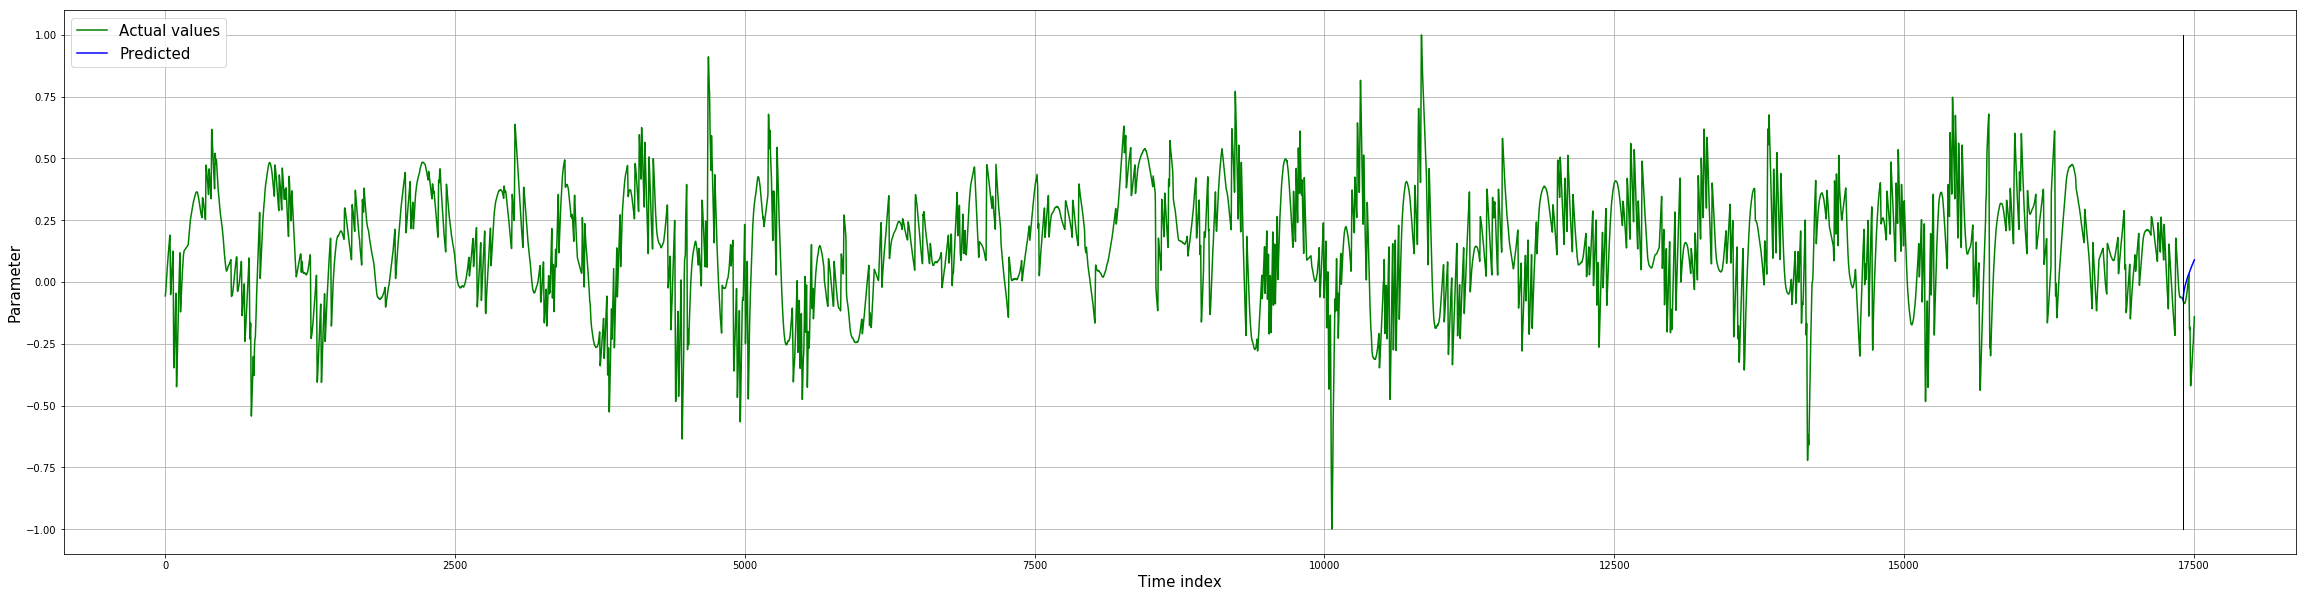

In [ ]:
plot_results(actual_time_series = scaled_y,
             predicted_values = forecast, 
             len_train_data = len(x_train))

In [ ]:
def make_forecast(train_data, len_forecast: int, window_size: int, final_model: str = 'ridge'):
    """
    Function for predicting values in a time series
    
    :param train_data: one-dimensional numpy array to train pipeline
    :param len_forecast: amount of values for predictions
    :param window_size: moving window size
    :param final_model: model in the root node

    :return predicted_values: numpy array, forecast of model
    """
    
    # Here we define which task should we use, here we also define two main forecast length
    task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=len_forecast))

    # Prepare data to train the model
    train_input = InputData(idx=np.arange(0, len(train_data)),
                            features=train_data,
                            target=train_data,
                            task=task,
                            data_type=DataTypesEnum.ts)

    # Prepare input data for prediction part
    start_forecast = len(train_data)
    end_forecast = start_forecast + len_forecast
    # Create forecast indices 
    forecast_idx = np.arange(start_forecast, end_forecast)
    predict_input = InputData(idx=forecast_idx,
                              features=train_data,
                              target=y_test,
                              task=task,
                              data_type=DataTypesEnum.ts)
    
    # Create a pipeline "lagged -> " 
    node_lagged = PrimaryNode('lagged')
    
    # Define parameters to certain node 
    node_lagged.custom_params = {'window_size': window_size}
    node_ridge = SecondaryNode(final_model, nodes_from=[node_lagged])
    ridge_pipeline = Pipeline(node_ridge)

    # Fit pipeline
    ridge_pipeline.fit(train_input)

    # Predict. Pipeline return OutputData object 
    predicted_output = ridge_pipeline.predict(predict_input)

    # Convert forecasted values into one-dimensional array
    forecast = np.ravel(np.array(predicted_output.predict))

    return forecast


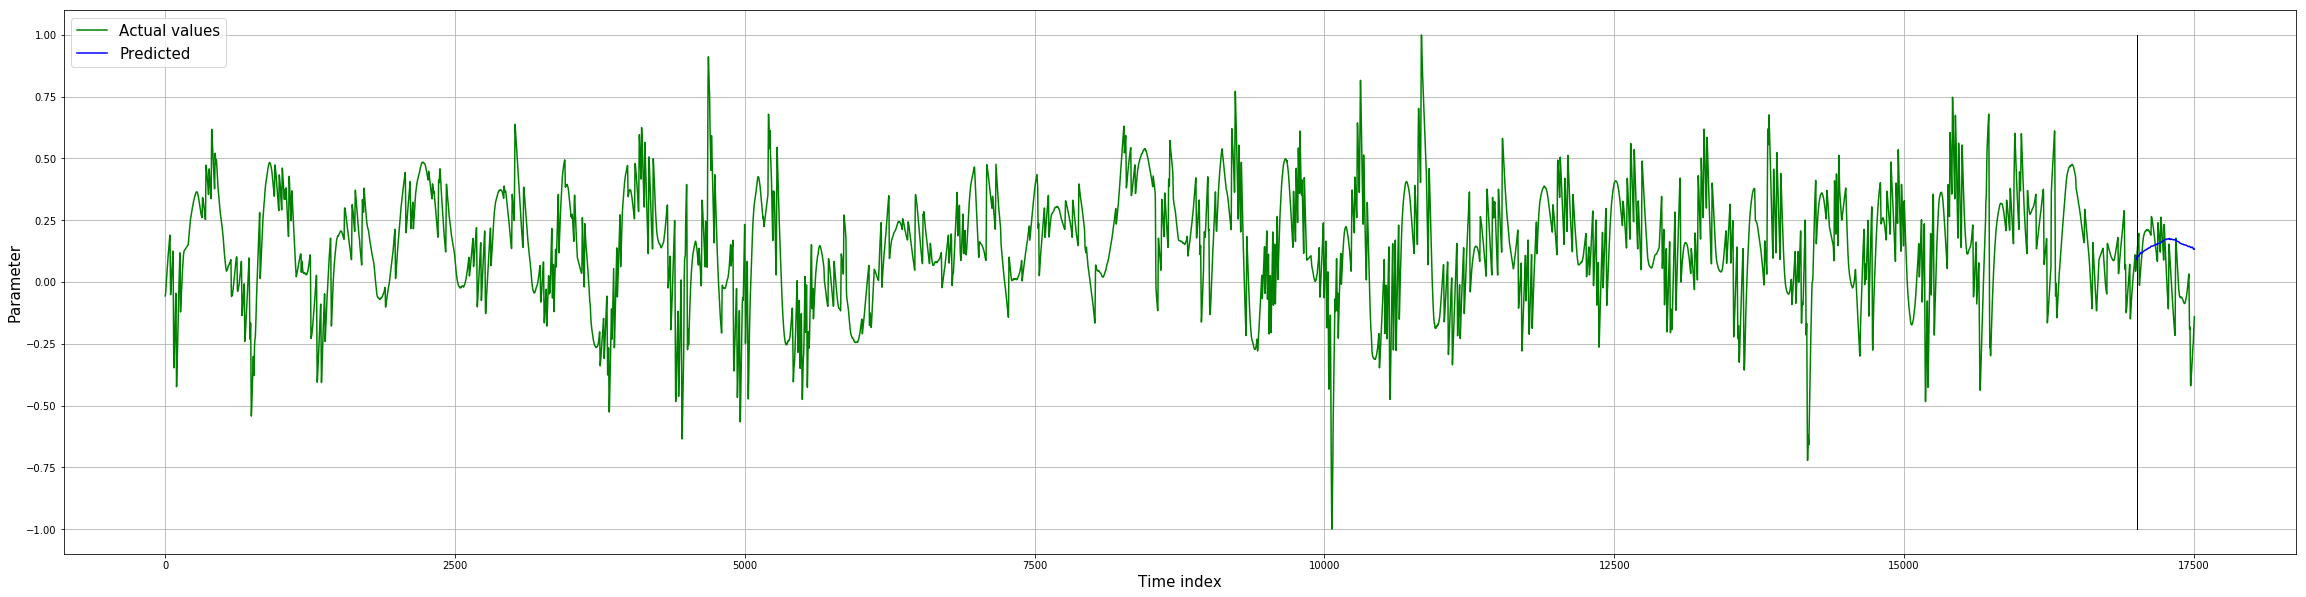

In [ ]:
predicted_values = make_forecast(train_data = y_train, 
                                 len_forecast = 500,
                                 window_size = 200)

plot_results(actual_time_series = scaled_y,
             predicted_values = predicted_values, 
             len_train_data = len(y_train))

In [ ]:
# model = Fedot(problem='ts_forecasting', timeout=2, logging_level = 1, preset='best_quality', n_jobs=-1)
# model.fit(features=feature_train, target=label_train)
# prediction = model.predict(features=feature_test)
# metrics = model.get_metrics(target=label_test)

In [ ]:
# def make_feature_set_train(x_, y_, size_n):

#     features_set = []
#     labels = []

#     n = size_n
#     k = 1

#     for i in range(n, len(x_)-k):
#         feature_i = np.array([[x_[i-n:i, 0]], [y_[i-n:i, 0]]])
#         feature_i = feature_i.reshape((feature_i.shape[0], feature_i.shape[2]))
#         features_set.append(feature_i)
#         labels.append(y_[i:i+k, 0])

#     features_set, labels = np.array(features_set), np.array(labels)
#     print(features_set[0].shape)
#     print(features_set.shape, labels.shape)

#     return features_set, labels

In [ ]:
# def make_feature_set_test(x_, y_, size_n):

#     features_set = []
#     labels = []

#     n = size_n
#     k = 1

#     for i in range(n, len(x_)):
#         features_set.append(x_[i-n:i, 0])
#         labels.append(y_[i-k:i, 0])

#     features_set, labels = np.array(features_set), np.array(labels)
#     features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
#     labels = np.reshape(labels, (labels.shape[0], labels.shape[1], 1))

#     print(features_set.shape, labels.shape)

#     return features_set, labels

In [ ]:
size_n = 60
feature_train, label_train = make_feature_set_train(x_train, y_train, size_n)
feature_test, label_test = make_feature_set_train(x_test, y_test, size_n)

(2, 60)
(45157, 2, 60) (45157, 1)
(2, 60)
(17450, 2, 60) (17450, 1)


In [ ]:
import tensorflow as tf

In [ ]:
linear = tf.keras.models.Sequential()
linear.add(tf.keras.Input(shape=(2, feature_train.shape[2])))
linear.add(tf.keras.layers.Dense(40, activation='tanh'))
linear.add(tf.keras.layers.Dense(20, activation='tanh'))
linear.add(tf.keras.layers.Dense(1))
linear.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss = 'mse')

In [ ]:
linear.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 2, 40)             2440      
                                                                 
 dense_4 (Dense)             (None, 2, 20)             820       
                                                                 
 dense_5 (Dense)             (None, 2, 1)              21        
                                                                 
Total params: 3,281
Trainable params: 3,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
result_linear = linear.fit(feature_train, label_train, epochs = 100, batch_size = 8, validation_split=0.2)

Epoch 1/100
4516/4516 [==============================] - 10s 2ms/step - loss: 0.0807 - val_loss: 0.0442
Epoch 2/100
4516/4516 [==============================] - 9s 2ms/step - loss: 0.0758 - val_loss: 0.0425
Epoch 3/100
4516/4516 [==============================] - 9s 2ms/step - loss: 0.0737 - val_loss: 0.0461
Epoch 4/100
4516/4516 [==============================] - 9s 2ms/step - loss: 0.0721 - val_loss: 0.0424
Epoch 5/100
4516/4516 [==============================] - 9s 2ms/step - loss: 0.0709 - val_loss: 0.0443
Epoch 6/100
4516/4516 [==============================] - 9s 2ms/step - loss: 0.0698 - val_loss: 0.0439
Epoch 7/100
4516/4516 [==============================] - 9s 2ms/step - loss: 0.0687 - val_loss: 0.0419
Epoch 8/100
4516/4516 [==============================] - 9s 2ms/step - loss: 0.0674 - val_loss: 0.0408
Epoch 9/100
4516/4516 [==============================] - 9s 2ms/step - loss: 0.0662 - val_loss: 0.0374
Epoch 10/100
4516/4516 [==============================] - 9s 2ms/step - 

In [ ]:
# u = 50
# model_lstm = tf.keras.models.Sequential()
# model_lstm.add(tf.keras.layers.LSTM(units= u, return_sequences=True, input_shape=(feature_train.shape[1], 2)))
# model_lstm.add(tf.keras.layers.Dropout(0.4))

# model_lstm.add(tf.keras.layers.LSTM(units=u))
# model_lstm.add(tf.keras.layers.Dropout(0.2))

# model_lstm.add(tf.keras.layers.Dense(units = label_train.shape[1]))

# model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss = 'mean_squared_error')

In [ ]:
# model_lstm.summary()

In [ ]:
# result_lstm = model_lstm.fit(feature_train, label_train, epochs = 20, batch_size = 32, validation_split=0.2)

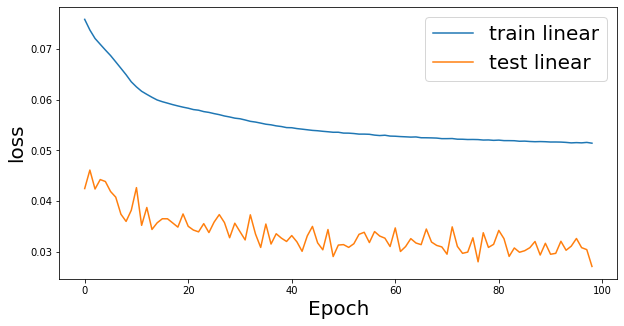

In [ ]:
plt.figure(figsize=(10,5), facecolor='w')
# plt.plot(result_lstm.history['loss'][1:], label='train LSTM')
# plt.plot(result_lstm.history['val_loss'][1:], label='test LSTM')
plt.plot(result_linear.history['loss'][1:], label='train linear')
plt.plot(result_linear.history['val_loss'][1:], label='test linear')
plt.legend(fontsize=20)
plt.xlabel('Epoch',  fontsize=20)
plt.ylabel('loss',  fontsize=20)
plt.show()

In [ ]:
predictions_linear = linear.predict(feature_test)
# predictions_lstm = model_lstm.predict(feature_test)

546/546 [==============================] - 1s 1ms/step


In [ ]:
predictions_linear[:,0]

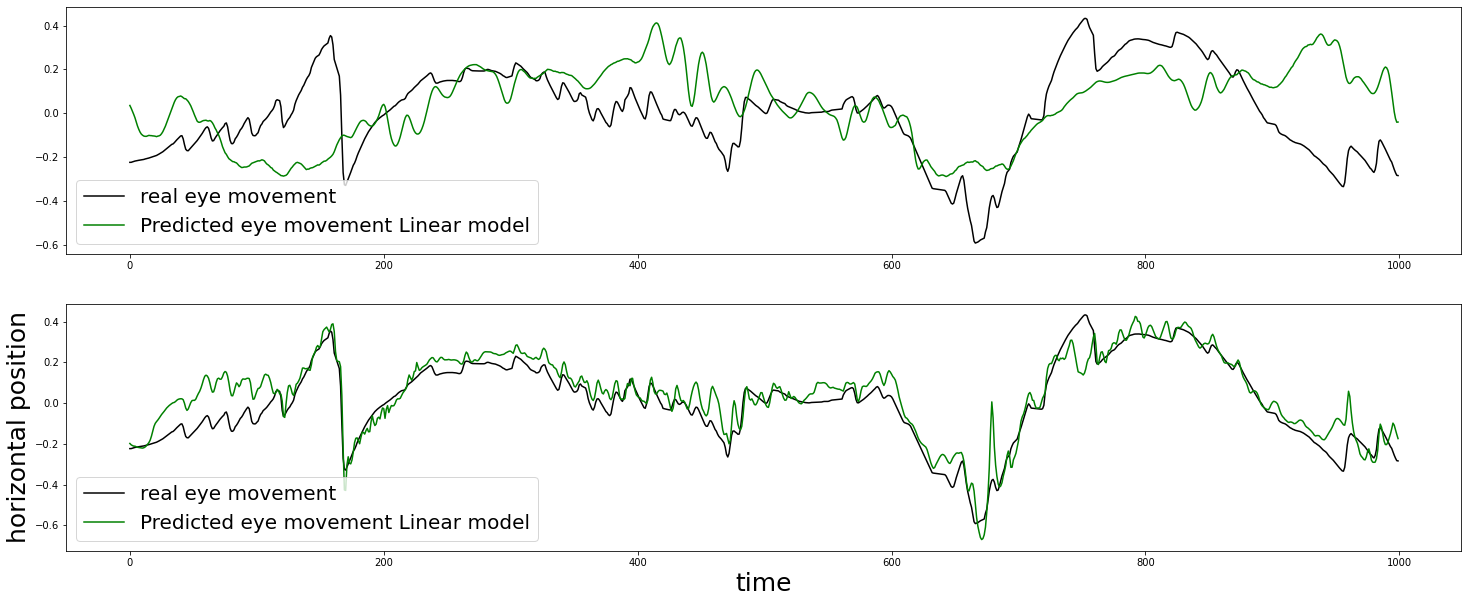

In [ ]:
y_test = y_test.reshape((y_test.shape[0],))
fig, ax = plt.subplots(ncols=1, nrows = 2, figsize=(25, 10))
fig.patch.set_facecolor('white')
n1 = 1000
n2 = 2000

# ax[0].plot(y_test[n1+60:n2+60], color='black', label='real eye movement')
# ax[0].plot(predictions_lstm[n1:n2], color='blue', label='Predicted eye movement LSTM')

ax[0].plot(y_test[n1+60:n2+60], color='black', label='real eye movement')
ax[0].plot(predictions_linear[:,0][n1:n2], color='green', label='Predicted eye movement Linear model')

ax[1].plot(y_test[n1+60:n2+60], color='black', label='real eye movement')
ax[1].plot(predictions_linear[:,1][n1:n2], color='green', label='Predicted eye movement Linear model')

plt.xlabel('time', fontsize=25)
plt.ylabel('horizontal position', fontsize=25)

ax[0].legend(fontsize=20)
ax[1].legend(fontsize=20)

plt.show()

In [ ]:
# x_train2 = scaled_x5
# y_train2 = scaled_y5
# x_test2 = scaled_x5[0:5000]
# y_test2 = scaled_y5[0:5000]

In [ ]:
# x_scaler = MinMaxScaler((-1,1))
# y_scaler = MinMaxScaler((-1,1))

# scaled_x_train = x_scaler.fit_transform(x_train2)
# scaled_y_train = y_scaler.fit_transform(y_train2)

# scaled_x_test = x_scaler.transform(x_test2)
# scaled_y_test = y_scaler.transform(y_test2)

In [ ]:
# size_n = 100
# feature_train, label_train = make_feature_set(x_train2, y_train2, size_n)
# feature_test, label_test = make_feature_set(x_test2, y_test2, size_n)